In [2]:
import os

from kloppy import sportec
import pandas as pd
from tqdm import tqdm

import pandas as pd
root_path = "../../../rdf/sp161/shared/soccer-decision-making-r/sportec"
game = "DFL-MAT-J03YKP.xml"



In [3]:
event = sportec.load_event(
        event_data= f"{root_path}/event/{game}",
        meta_data=f"{root_path}/match_information/{game}",
        coordinates="sportec",
        event_types=["pass"],
    ).to_df()

event['event_id'] = event['event_id'].astype(int)
event['match_id'] = game
tracking = sportec.load_tracking(
        raw_data= f"{root_path}/tracking/xml/{game}",
        meta_data=f"{root_path}/match_information/{game}",
        sample_rate=1,
        coordinates="sportec",
        only_alive=False,
    ).to_df()

In [10]:
kpi_path = f"{root_path}/KPI_Merged_all/KPI_MGD_{game[:-4]}.csv"
kpi_df = pd.read_csv(kpi_path ,sep = ';', encoding='latin-1', on_bad_lines='skip')

kpi_df[kpi_df['EVENT_ID'] == 18477700000007]['FRAME_NUMBER']

1    10068
Name: FRAME_NUMBER, dtype: int64

In [11]:
event[event['event_id'] == 18477700000007]['timestamp']

1   0 days 00:00:02.438000
Name: timestamp, dtype: timedelta64[ns]

In [12]:
def tracking_wide_to_long(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts wide kloppy output of tracking data to more manageable long format

    Inputs:
        df - wide kloppy output
    Returns
        df in long format
    """
    track_cols = [c for c in df.columns if c.startswith("DFL-OBJ-") and c.count("_") >= 1]

    id_cols = [c for c in df.columns if c not in track_cols]
    m = df.melt(
        id_vars=id_cols,
        value_vars=track_cols,
        var_name="var",
        value_name="value"
    )
    obj_metric = m["var"].str.rsplit("_", n=1, expand=True)
    m["object_id"] = obj_metric[0]
    m["metric"] = obj_metric[1]

    m = m.drop(columns=["var"])

    long_df = (
        m.pivot_table(
            index=id_cols + ["object_id"],
            columns="metric",
            values="value",
            aggfunc="first" 
        )
        .reset_index()
    )

    long_df.columns.name = None

    return long_df

def add_ball_rows(df_wide: pd.DataFrame, players_long: pd.DataFrame) -> pd.DataFrame:
    """
    Replaces ball columns with its own designated row in the tracking data to avoid unnecessary duplicates
    """
    key_cols = ["period_id", "timestamp", "frame_id", "ball_state", "ball_owning_team_id"]

    ball_long = (
        df_wide[key_cols + ["ball_x", "ball_y", "ball_z", "ball_speed"]]
        .rename(columns={"ball_speed": "s"})
        .assign(
            object_id="BALL",
            x=lambda d: d["ball_x"],
            y=lambda d: d["ball_y"],
            z=lambda d: d["ball_z"],
        )
        .drop(columns=["ball_x", "ball_y", "ball_z"])
    )

    out = pd.concat([players_long, ball_long], ignore_index=True, sort=False)
    return out.drop(columns = ["ball_x", "ball_y", "ball_z", "ball_speed"])

In [13]:
import xml.etree.ElementTree as ET
def build_player_map(path): 
    tree = ET.parse(path) 
    root = tree.getroot() 
    data = {} 
    for root_elem in root.findall('.//Team'): 
        TeamId = root_elem.attrib.get('TeamId') 
        for elem in root_elem.findall('.//Player'): 
            data[elem.attrib.get('PersonId')] = TeamId 
    return data
player_map = build_player_map(f"/home/lz80/rdf/sp161/shared/soccer-decision-making-r/sportec/match_information/{game}")
player_map['BALL'] = 'BALL'

In [ ]:
t = tracking[tracking['frame_id'].isin(range(10055, 10080))]
c_frame = tracking_wide_to_long(t)
c_frame_ball = add_ball_rows(t, c_frame)
c_frame_ball['team'] = c_frame_ball['object_id'].map(player_map)

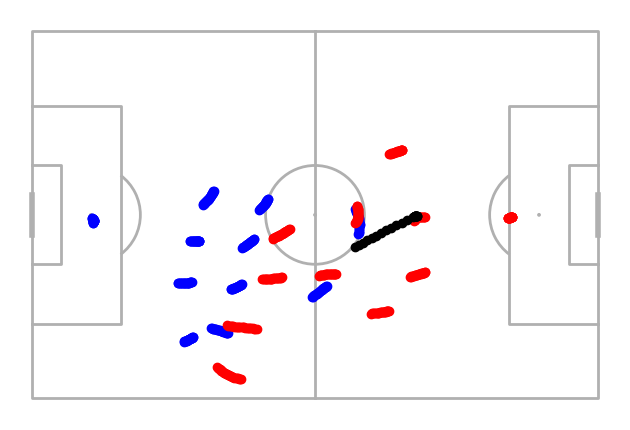

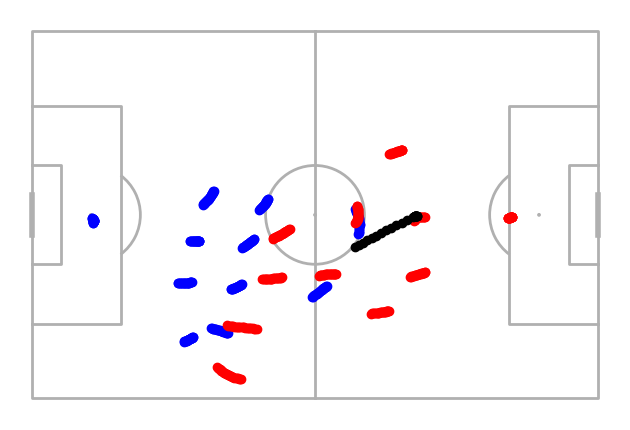

In [33]:
from mplsoccer import Pitch


def plot_state(tracking):
    pitch = Pitch(pitch_type='custom',  # example plotting a tracab pitch
              pitch_length=105, pitch_width=68)
    fig, ax = pitch.draw()
    t1 = tracking[tracking['team'] == 'DFL-CLU-000003']
    t2 = tracking[tracking['team'] == 'DFL-CLU-000004']
    ball = tracking[tracking['team'] == 'BALL']

    pitch.scatter(t1['x'] + 105/2, t1['y'] + 34, color = 'blue', ax = ax)
    pitch.scatter(t2['x']+ 105/2, t2['y'] + 34, color = 'red', ax = ax)
    pitch.scatter(ball['x'] + 105/2, ball['y'] + 34, color = 'black', ax =ax)
    
    return fig
plot_state(c_frame_ball)


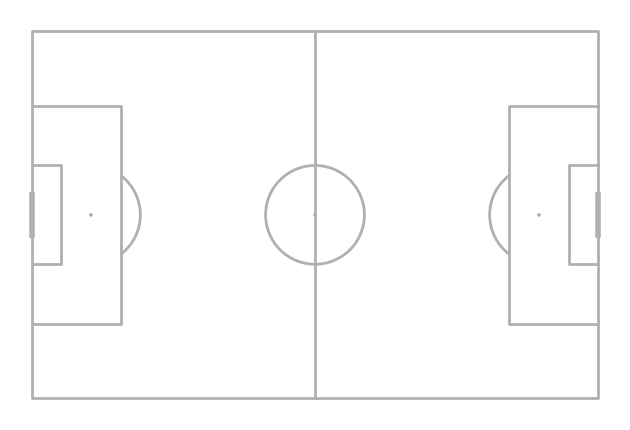

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mplsoccer import Pitch

def animate_event(
    tracking,
    team1_id="DFL-CLU-000003",
    team2_id="DFL-CLU-000004",
    ball_id="BALL",
    frame_col="frame_id",      # or "timestamp"
    pitch_length=105,
    pitch_width=68,
):
    """
    Create an animation of a tracking event.

    tracking: pd.DataFrame with columns [frame_col, team, x, y]
              one row per entity per frame.
    save_path: if provided, saves animation to mp4/gif (based on extension).
    Returns: (fig, anim)
    """

    # Unique frames in order
    frames = np.sort(tracking[frame_col].unique())

    # Pitch setup
    pitch = Pitch(
        pitch_type="custom",
        pitch_length=pitch_length,
        pitch_width=pitch_width
    )
    fig, ax = pitch.draw()

    # Create empty scatter artists once (then update their offsets each frame)
    scat_t1 = pitch.scatter([], [], ax=ax)
    scat_t2 = pitch.scatter([], [], ax=ax)
    scat_ball = pitch.scatter([], [], ax=ax)

    # Style them
    scat_t1.set_color("blue")
    scat_t2.set_color("red")
    scat_ball.set_color("black")

    # Optional: nicer sizing
    scat_t1.set_sizes([40])
    scat_t2.set_sizes([40])
    scat_ball.set_sizes([25])

    # If you want frame label on plot
    title = ax.set_title("")

    def to_pitch_xy(df):
        # Your original code shifts coords from centered to pitch coords
        x = df["x"].to_numpy() + pitch_length / 2
        y = df["y"].to_numpy() + pitch_width / 2
        return np.column_stack([x, y])

    def init():
        scat_t1.set_offsets(np.empty((0, 2)))
        scat_t2.set_offsets(np.empty((0, 2)))
        scat_ball.set_offsets(np.empty((0, 2)))
        title.set_text("")
        return scat_t1, scat_t2, scat_ball, title

    def update(i):
        fr = frames[i]
        f = tracking[tracking[frame_col] == fr]

        t1 = f[f["team"] == team1_id]
        t2 = f[f["team"] == team2_id]
        ball = f[f["team"] == ball_id]

        scat_t1.set_offsets(to_pitch_xy(t1) if len(t1) else np.empty((0, 2)))
        scat_t2.set_offsets(to_pitch_xy(t2) if len(t2) else np.empty((0, 2)))
        scat_ball.set_offsets(to_pitch_xy(ball) if len(ball) else np.empty((0, 2)))

        title.set_text(f"{frame_col}: {fr}")
        return scat_t1, scat_t2, scat_ball, title

    anim = FuncAnimation(
        fig,
        update,
        frames=len(frames),
        init_func=init,
        blit=True
    )


    return fig, anim


# # Example usage:
fig, anim = animate_event(c_frame_ball, frame_col="frame_id")


In [41]:
from IPython.display import HTML
[10068, 10061]
HTML(anim.to_jshtml())

anim.save(
    "pass.gif",
    writer="pillow",
    fps=1
)